In [1]:
# === Install all required dependencies ===
!pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn lightgbm xgboost --quiet

# === Imports for EDA, ML, and Visualization ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import arff
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    matthews_corrcoef, log_loss, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

print("✅ All libraries successfully installed and imported.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.1 MB/s eta 0:00:00
✅ All libraries successfully installed and imported.


=== Loaded CM1 dataset ===
Shape: (327, 38)
Columns: ['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'CYCLOMATIC_DENSITY', 'DECISION_COUNT', 'DECISION_DENSITY', 'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT', 'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE', 'PARAMETER_COUNT', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MAINTENANCE_SEVERITY', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS', 'NUMBER_OF_LINES', 'PERCENT_COMMENTS', 'LOC_TOTAL', 'Defective']

Label distribution:
Defective
0    285
1     42
Name: count, dtype: int64

=== Summary Statistics ===
        LOC_BLANK  BRANCH_COUNT  CALL_PAIRS  LOC_CODE_AND_COMMENT  \
count  327.00000

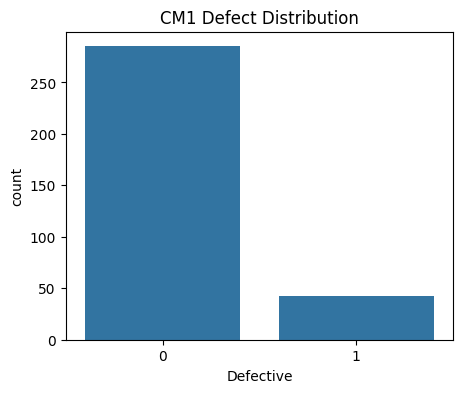

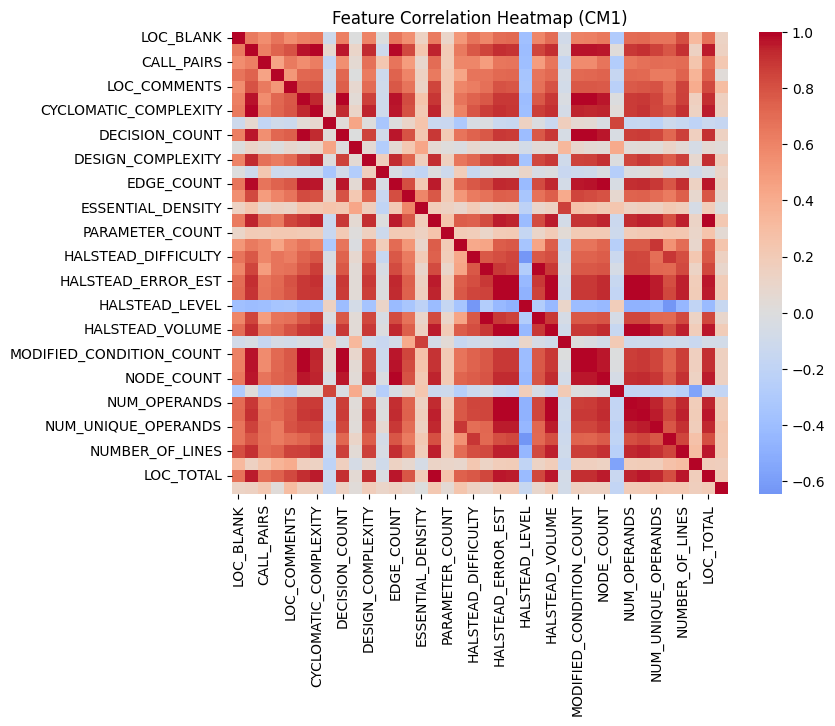

In [2]:
# Step 1: Load and Explore CM1 Dataset
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load CM1.arff
data, meta = arff.loadarff('/content/CM1.arff')
df_cm1 = pd.DataFrame(data)

# Convert byte columns to string
df_cm1 = df_cm1.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Identify label column
possible_labels = [col for col in df_cm1.columns if 'defect' in col.lower() or 'class' in col.lower()]
if possible_labels:
    target_col = possible_labels[0]
else:
    raise ValueError("No label column found. Please rename target column to 'defects' or similar.")

# Convert label column to binary
df_cm1[target_col] = df_cm1[target_col].replace({
    'Y': 1, 'N': 0, 'Yes': 1, 'No': 0, 'true': 1, 'false': 0, True: 1, False: 0
}).astype(int)

print(f"=== Loaded CM1 dataset ===")
print(f"Shape: {df_cm1.shape}")
print(f"Columns: {list(df_cm1.columns)}\n")

print("Label distribution:")
print(df_cm1[target_col].value_counts())

# Summary stats
print("\n=== Summary Statistics ===")
print(df_cm1.describe())

# Missing values
print("\nMissing values:")
print(df_cm1.isnull().sum().sort_values(ascending=False).head())

# ---- EDA Visualization ----
plt.figure(figsize=(5,4))
sns.countplot(x=target_col, data=df_cm1)
plt.title("CM1 Defect Distribution")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df_cm1.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (CM1)")
plt.show()


Original shape: (327, 37), Class distribution: [285  42]
After variance threshold: (327, 37)
Dropping highly correlated features: ['CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'DESIGN_COMPLEXITY', 'EDGE_COUNT', 'LOC_EXECUTABLE', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUMBER_OF_LINES', 'LOC_TOTAL']
After correlation filter: (327, 19)

Top 10 features by mutual information:
 CALL_PAIRS              0.067742
LOC_COMMENTS            0.056935
NUM_UNIQUE_OPERATORS    0.048058
HALSTEAD_CONTENT        0.041581
DESIGN_DENSITY          0.036832
ESSENTIAL_DENSITY       0.036075
PERCENT_COMMENTS        0.033218
MAINTENANCE_SEVERITY    0.022613
HALSTEAD_LEVEL          0.020175
PARAMETER_COUNT         0.019229
dtype: float64

Selected features via RFE: ['LOC_BLANK', 'CALL_PAIRS', 'LOC_COMMENTS', 'DESIGN_DENSITY', 'H

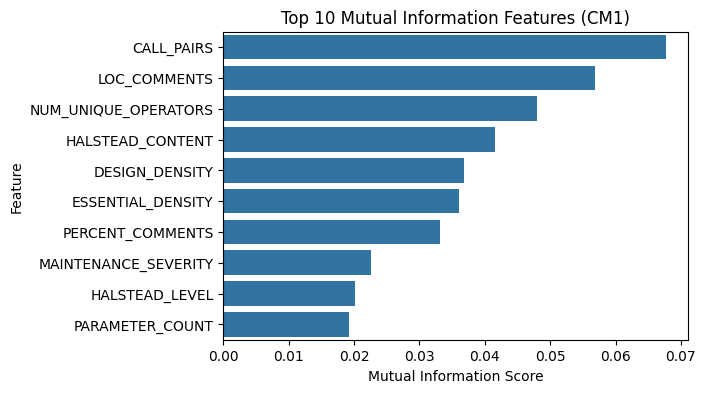

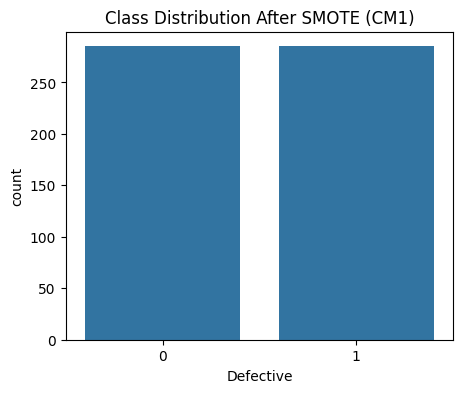

In [3]:
# === Step 2: Feature Selection + Balancing for CM1 ===
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Split features and target
X = df_cm1.drop(columns=['Defective'])
y = df_cm1['Defective']

print(f"Original shape: {X.shape}, Class distribution: {np.bincount(y)}")

# --- Step 1: Remove low variance features ---
var_thresh = VarianceThreshold(threshold=0.0)
X_var = X.loc[:, var_thresh.fit(X).get_support()]
print(f"After variance threshold: {X_var.shape}")

# --- Step 2: Remove highly correlated features ---
corr_matrix = X_var.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_corr = X_var.drop(columns=to_drop)
print(f"Dropping highly correlated features: {to_drop}")
print(f"After correlation filter: {X_corr.shape}")

# --- Step 3: Mutual Information ---
mi_scores = mutual_info_classif(X_corr, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X_corr.columns).sort_values(ascending=False)
print("\nTop 10 features by mutual information:\n", mi_series.head(10))

# --- Step 4: Recursive Feature Elimination (RFE) ---
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X_corr, y)
selected_features = X_corr.columns[rfe.support_].tolist()
print(f"\nSelected features via RFE: {selected_features}")

X_sel = X_corr[selected_features]

# --- Step 5: SMOTE Balancing ---
smote = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = smote.fit_resample(X_sel, y)
print(f"\nBefore SMOTE class distribution: {np.bincount(y)}")
print(f"After SMOTE class distribution: {np.bincount(y_res)}")
print(f"Resampled shape: {X_res.shape}")

# --- Visualization ---
plt.figure(figsize=(6,4))
sns.barplot(x=mi_series.head(10), y=mi_series.head(10).index)
plt.title("Top 10 Mutual Information Features (CM1)")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x=y_res)
plt.title("Class Distribution After SMOTE (CM1)")
plt.show()


Train shape: (427, 10), Test shape: (143, 10)
RF best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} CV AUC: 0.9629452213551726
ET best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} CV AUC: 0.9797561101238765
XGB done
[LightGBM] [Info] Number of positive: 214, number of negative: 213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 427, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501171 -> initscore=0.004684
[LightGBM] [Info] Start training from score 0.004684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

,Model,AUC,PR-AUC,F1,Precision,Recall,MCC,Accuracy,LogLoss
1,ExtraTrees_Tuned,0.992958,0.992586,0.958904,0.933333,0.985915,0.917549,0.958042,0.208094
4,Stacking_Ensemble,0.991491,0.989292,0.979310,0.959459,1.000000,0.958896,0.979021,0.116462
0,RandomForest_Tuned,0.979167,0.978770,0.906667,0.860759,0.957746,0.809414,0.902098,0.245118
2,XGBoost,0.972027,0.953323,0.926174,0.884615,0.971831,0.850331,0.923077,0.211388
3,LightGBM,0.970657,0.940307,0.920000,0.873418,0.971831,0.837542,0.916084,0.242782


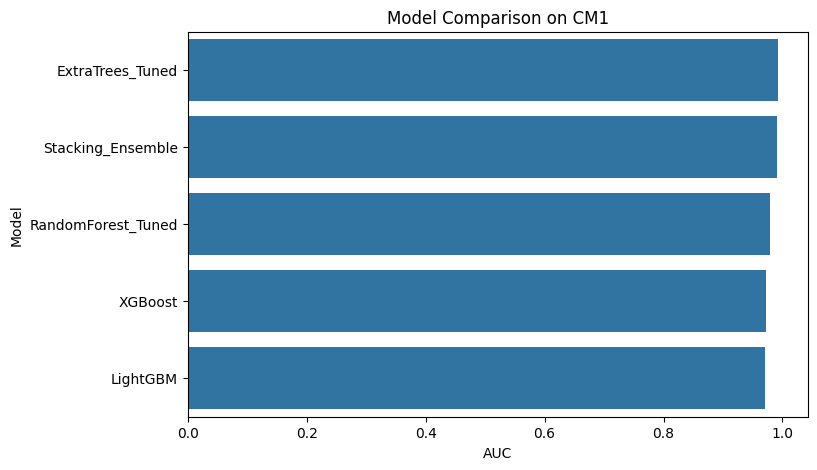

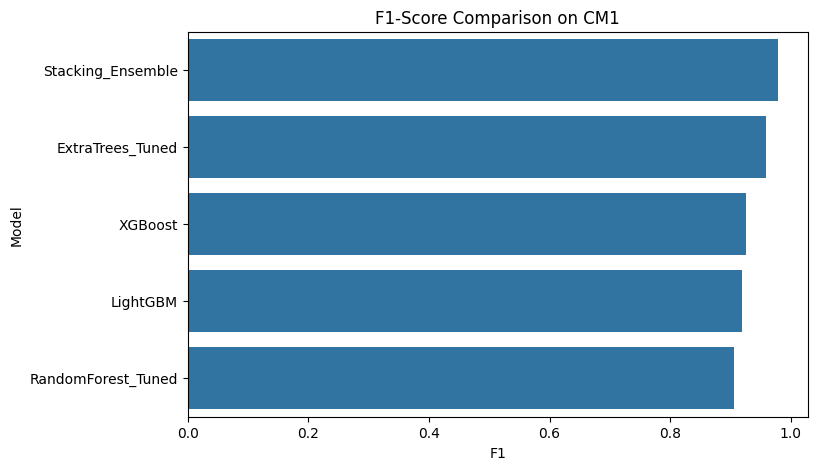

Saved stacking model and results CSV.


In [4]:
# === Step 3: Ensemble Model Training & Evaluation for CM1 ===
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, log_loss, classification_report
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
import xgboost as xgb
import lightgbm as lgb
import joblib

# 1) Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.25, random_state=42, stratify=y_res
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 2) Random Forest tuning
rf_params = {
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42),
                  rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf.fit(X_train, y_train)
print("RF best:", rf.best_params_, "CV AUC:", rf.best_score_)

# 3) Extra Trees tuning
et_params = {
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5]
}
et = GridSearchCV(ExtraTreesClassifier(random_state=42),
                  et_params, cv=5, scoring='roc_auc', n_jobs=-1)
et.fit(X_train, y_train)
print("ET best:", et.best_params_, "CV AUC:", et.best_score_)

# 4) XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, eval_metric='logloss',
    random_state=42, use_label_encoder=False
)
xgb_model.fit(X_train, y_train)
print("XGB done")

# 5) LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=-1,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
lgb_model.fit(X_train, y_train)
print("LGB done")

# 6) Stacking Ensemble
estimators = [
    ('rf', rf.best_estimator_),
    ('et', et.best_estimator_),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=ExtraTreesClassifier(n_estimators=200, random_state=42),
    passthrough=True, n_jobs=-1
)
stack.fit(X_train, y_train)
print("Stacking trained")

# 7) Evaluate each model
models = {
    "RandomForest_Tuned": rf.best_estimator_,
    "ExtraTrees_Tuned": et.best_estimator_,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "Stacking_Ensemble": stack
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(rec, prec)
    ll = log_loss(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec_val = precision_score(y_test, y_pred)
    rec_val = recall_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred)
    mcc_val = matthews_corrcoef(y_test, y_pred)

    print(f"\n--- {name} ---")
    print(f"AUC: {roc_auc:.4f}  PR-AUC: {pr_auc:.4f}  "
          f"F1: {f1_val:.4f}  Precision: {prec_val:.4f}  "
          f"Recall: {rec_val:.4f}  MCC: {mcc_val:.4f}  "
          f"Acc: {acc:.4f}  LogLoss: {ll:.4f}")
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", classification_report(y_test, y_pred))

    results.append([name, roc_auc, pr_auc, f1_val,
                    prec_val, rec_val, mcc_val, acc, ll])

# 8) Results table
results_df = pd.DataFrame(results, columns=[
    'Model','AUC','PR-AUC','F1','Precision','Recall','MCC','Accuracy','LogLoss'
])
display(results_df.sort_values('AUC', ascending=False))

# 9) Visualization – comparison bars
plt.figure(figsize=(8,5))
sns.barplot(x='AUC', y='Model', data=results_df.sort_values('AUC', ascending=False))
plt.title("Model Comparison on CM1")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='F1', y='Model', data=results_df.sort_values('F1', ascending=False))
plt.title("F1-Score Comparison on CM1")
plt.show()

# 10) Save model/results
joblib.dump(stack, "/content/cm1_stacking_model.pkl")
results_df.to_csv("/content/cm1_model_results_holdout.csv", index=False)
print("Saved stacking model and results CSV.")
